## Genome Manual Transformation Demo
Show a program can successfully evolve from BFS to DFS using manual transformations
1. Directly on XML elements
2. Using Genome representation

In [1]:
import os, json

from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker

from models import Prototypes, Ingredient, Base

dfs_hash = 'ffc9d4101c16b26beb74bedb363ecf0a63aab0145bbe379e43f950fdef0b44e0'
bfs_hash = '80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204'

# Import settings
setting_file = os.path.abspath(os.path.join('..', 'settings.json'))

with open(setting_file, 'r') as f:
    settings = json.load(f)

# connect to database
# create engine, connection, and session
engine = create_engine(settings['sqlalchemy_database_uri'])
conn = engine.connect()
Session = sessionmaker(bind=engine)
session = Session()

# create tables
Base.metadata.create_all(engine)

prototype_dfs = session.query(Prototypes).filter(Prototypes.hash == dfs_hash).first()
prototype_bfs = session.query(Prototypes).filter(Prototypes.hash == bfs_hash).first()

In [2]:
# write everything to files
dfs_code_filepath = os.path.join('tmp', 'dfs.c')
with open(dfs_code_filepath, 'w') as f:
    f.write(prototype_dfs.code)

bfs_code_filepath = os.path.join('tmp', 'bfs.c')
with open(bfs_code_filepath, 'w') as f:
    f.write(prototype_bfs.code)

dfs_xml_filepath = os.path.join('tmp', 'dfs.xml')
with open(dfs_xml_filepath, 'w') as f:
    f.write(prototype_dfs.xml)

bfs_xml_filepath = os.path.join('tmp', 'bfs.xml')
with open(bfs_xml_filepath, 'w') as f:
    f.write(prototype_bfs.xml)

In [3]:
import xml.etree.ElementTree as ET

# get tree for each genome
dfs_tree = ET.parse(dfs_xml_filepath)
bfs_tree = ET.parse(bfs_xml_filepath)

# get root for each genome
dfs_root = dfs_tree.getroot()
bfs_root = bfs_tree.getroot()

bfs_elems = list(bfs_root.iter())
dfs_elems = list(dfs_root.iter())

In [4]:
def swap_element(org_tree, org_elem, donor_elem):
    """ 
    Swaps an element in the original tree with an element in the donor tree.
    
    Args:
        org_tree (ElementTree): the original tree
        org_elem (Element): the element to be swapped
        donor_elem (Element): the donor element

    Returns:
        ElementTree: the original tree with the elements swapped
    """
    org_root = org_tree.getroot()

    # parent map keeps track of the parent of each element in the xml
    parent_map = {c: p for p in org_root.iter() for c in p}

    for elem in org_root.iter():
        if elem == org_elem:
            parent = parent_map[elem]
            # find the position of the element in the parent
            i = 0
            for child in parent:
                if child == elem:
                    break
                i += 1
            # remove element from original tree and insert the donor element in its place
            parent.remove(elem)
            parent.insert(i, donor_elem)
            break

    return org_tree

In [5]:
# write all elements in the tree along with position and parent
with open('tmp/bfs_elements.txt', 'w') as f:
    root = bfs_tree.getroot()
    pos = 0
    parent_map = {c: p for p in root.iter() for c in p}
    for elem in root.iter():
        if elem in parent_map:
            out = f"{pos} {elem.tag.split('}')[1]} {elem.attrib} {elem.text} {parent_map[elem].tag.split('}')[1]}"
        else:
            out = f"{pos} {elem.tag.split('}')[1]} {elem.attrib} {elem.text}"
        f.write(out + '\n')
        pos += 1

with open('tmp/dfs_elements.txt', 'w') as f:
    root = dfs_tree.getroot()
    pos = 0
    parent_map = {c: p for p in root.iter() for c in p}
    for elem in root.iter():
        if elem in parent_map:
            out = f"{pos} {elem.tag.split('}')[1]} {elem.attrib} {elem.text} {parent_map[elem].tag.split('}')[1]}"
        else:
            out = f"{pos} {elem.tag.split('}')[1]} {elem.attrib} {elem.text}"
        f.write(out + '\n')
        pos += 1

In [6]:
# swap edits
edits = [
    (14, 14), # required
    (36, 33), # required
    (130, 118), # required
    (228, 161), # required
    (371, 252), # required
    # (397, 278), # optional
    (410, 317), # required
    # (423, 328), # optional
    # (459, 363), # optional
    # (573, 485), # optional
    # (592, 502), # optional
    # (729, 825), # optional
    # (740, 836) # optional
]


# use swap_root to swap elements in the tree
for edit in edits:
    org_elem = bfs_elems[edit[0]]
    donor_elem = dfs_elems[edit[1]]
    bfs_tree = swap_element(bfs_tree, org_elem, donor_elem)
    print(f"Swapped {org_elem.tag} at position {edit[0]} with {donor_elem.tag} at position {edit[1]}")

# write the new bfs genome to a new xml file
bfs_xml_filepath = os.path.join('tmp', 'new_bfs.xml')
bfs_tree.write(bfs_xml_filepath)

Swapped {http://www.srcML.org/srcML/src}struct at position 14 with {http://www.srcML.org/srcML/src}struct at position 14
Swapped {http://www.srcML.org/srcML/src}function at position 36 with {http://www.srcML.org/srcML/src}function at position 33
Swapped {http://www.srcML.org/srcML/src}function at position 130 with {http://www.srcML.org/srcML/src}function at position 118
Swapped {http://www.srcML.org/srcML/src}function at position 228 with {http://www.srcML.org/srcML/src}function at position 161
Swapped {http://www.srcML.org/srcML/src}decl at position 371 with {http://www.srcML.org/srcML/src}decl at position 252
Swapped {http://www.srcML.org/srcML/src}condition at position 410 with {http://www.srcML.org/srcML/src}condition at position 317


In [7]:
# Redo everything using the Genome class
from genome import Genome, Edit

bfs_genome = Genome(prototype_hash=bfs_hash, build_genome=True, session=session)

# let's turn that list of edits into an actual genome edits
for i in range(len(edits)):
    edit = Edit(edit_type='replace', prototype_position=edits[i][1], prototype_hash=dfs_hash)
    bfs_genome.chromosomes[edits[i][0]].edits.append(edit)

print(bfs_genome)

Position: 0, Tag: 'unit', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 33, Weight: 1, Parents: [], Edits: None
Position: 1, Tag: 'include', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 1, Weight: 1, Parents: [0], Edits: None
Position: 2, Tag: 'directive', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 0, Weight: 1, Parents: [1, 0], Edits: None
Position: 3, Tag: 'file', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 0, Weight: 1, Parents: [1, 0], Edits: None
Position: 4, Tag: 'include', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 1, Weight: 1, Parents: [0], Edits: None
Position: 5, Tag: 'directive', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 0, Weight: 1, Parents: [4, 0], Edits: None
Position: 6, Tag: 'file', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7

In [8]:
code = bfs_genome.get_code(srcML_path=settings['srcml_client'], session=session)

In [9]:
bfs_genome.get_code(srcML_path=settings['srcml_client'], session=session)
# submit to evaluation server
r = bfs_genome.submit_to_evaluation(evaluation_server=settings['evaluation_server'])
print(r)

{'message': 'error submitting to sandbox', 'unit_test_results': {'num_errors': 0, 'num_failures': 0, 'num_tests': 1}}


In [10]:
# let's look at the edits
for g in bfs_genome.chromosomes:
    if g.edits:
        print(g)

Position: 14, Tag: 'struct', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 5, Weight: 1, Parents: [0], Edits:
	Edit: replace with position 14 in prototype ffc9d4101c16b26beb74bedb363ecf0a63aab0145bbe379e43f950fdef0b44e0
Position: 36, Tag: 'function', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 15, Weight: 1, Parents: [0], Edits:
	Edit: replace with position 33 in prototype ffc9d4101c16b26beb74bedb363ecf0a63aab0145bbe379e43f950fdef0b44e0
Position: 130, Tag: 'function', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 14, Weight: 1, Parents: [0], Edits:
	Edit: replace with position 118 in prototype ffc9d4101c16b26beb74bedb363ecf0a63aab0145bbe379e43f950fdef0b44e0
Position: 228, Tag: 'function', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 15, Weight: 1, Parents: [0], Edits:
	Edit: replace with position 161 in prototype ffc9d4101c16b26beb74bedb

## Genetic Improvement Process Demo

In [11]:

# define genetic process
import random
from sqlalchemy.sql.expression import func
from sqlalchemy import and_, or_
import math

import concurrent.futures
from copy import deepcopy

def eval(genome):
    """wrapper function to evaluate a genome on the evaluation server"""
    return genome.submit_to_evaluation(evaluation_server=settings['evaluation_server'])

mutation_rate = 0.1
crossover_rate = 0.0 # this is just a placeholder for now
population_size = 100
donor_pool = [dfs_hash]
editable_tags = ['struct', 'function', 'decl', 'condition']

# create a population of genomes
population = []

# record min, max, and mean fitnesses for each generation
mean_fitnesses = []
max_fitnesses = []
min_fitnesses = []

num_generations = 200

for gen in range(num_generations):

    # add fresh genomes to the population (randomly shuffle the chromosomes in the genome)
    for i in range(population_size):
        genome = Genome(prototype_hash=bfs_hash, build_genome=True, session=session)
        # shuffle the chromosomes
        random.shuffle(genome.chromosomes)
        population.append(genome)

    children = []
    # apply mutations to the population at the mutation rate specified
    # enforce rules to reduce the search space
    for genome in population:
        child = deepcopy(genome)
        for chromosome in child.chromosomes:
            if chromosome.tag in editable_tags:
                if random.random() < mutation_rate:
                    # normally we would select from the possible edits
                    # but for now, all edits are replace
                    edit_type = 'replace'
                    # select a random edit from ingredients
                    max_depth = chromosome.depth + 1
                    min_depth = chromosome.depth - 1
                    tag = chromosome.tag
                    ingredient = session.query(Ingredient).filter(
                        and_(
                            Ingredient.depth.between(min_depth, max_depth),
                            Ingredient.prototype.in_(donor_pool),
                            Ingredient.tag == tag
                            )
                        ).order_by(func.random()).first()
                    if ingredient:
                        edit = Edit(edit_type=edit_type, prototype_position=ingredient.position, prototype_hash=ingredient.prototype)
                        # chromosome.edits.append(edit)
                        chromosome.edits = [edit]
                    else:
                        # print(f"Could not find ingredient for {tag} at depth {chromosome.depth}")
                        pass
        children.append(child)                    

    # add children to the population
    population.extend(children)
    
    # remove genomes with no edits
    population = [g for g in population if any([c.edits for c in g.chromosomes])]

    # calculate fitness for the population
    # get the code for each genome
    for genome in population:
        genome.get_code(srcML_path=settings['srcml_client'], session=session)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = [executor.submit(eval, genome) for genome in population]
    results = [r.result() for r in results]

    # get fitness for each genome
    for genome, result in zip(population, results):

        # get surrogate fitness as a placeholder for classification fitness
        num_edits = sum([len(c.edits) for c in genome.chromosomes])
        edit_fitness = max(0,((6 - abs(6 - num_edits)) / 6))

        if 'compile_errors' in result:
            errors = result['compile_errors']['errors']
            warnings = result['compile_errors']['warnings']
            
            error_penalty = 3  # errors to be worth 3x the penalty as a warning
            warning_penalty = 1
            compile_fitness = max(0, 1 - (math.log(errors * error_penalty + warnings * warning_penalty + 1,2)/10))
            genome.fitness = 0.5 * compile_fitness + 0.5 * edit_fitness
        else:
            genome.fitness = 0.5 + 0.5 * edit_fitness
        
    # sort the population by fitness
    population = sorted(population, key=lambda g: g.fitness, reverse=True)
    
    # select to 50% of the population survive
    population = population[:population_size // 2]

    # find min, max, and mean fitness of the population
    fitnesses = [g.fitness for g in population]
    min_fitness = min(fitnesses)
    max_fitness = max(fitnesses)
    mean_fitness = sum(fitnesses) / len(fitnesses)
    mean_fitnesses.append(mean_fitness)
    max_fitnesses.append(max_fitness)
    min_fitnesses.append(min_fitness)

    print(f"Generation {gen}: Min: {min_fitness}, Max: {max_fitness}, Mean: {mean_fitness}")




0.8333333333333334 0.46076825772212393
0.5 0.479054663437105
0.3333333333333333 0.7415037499278844
0.6666666666666666 0.48300749985576874
0.3333333333333333 0.4573735245297902
0.3333333333333333 0.42451124978365307
0.6666666666666666 0.4167109985835258
0.3333333333333333 0.5678071905112637
1.0 0.4
1.0 0.40458036896131244
0.6666666666666666 0.4093109404391482
0.3333333333333333 0.6093109404391481
0.6666666666666666 0.46424479953819164
0.8333333333333334 0.479054663437105
0.8333333333333334 0.5093109404391482
1.0 0.36962192518228965
0.8333333333333334 0.4
1.0 0.524511249783653
0.5 0.44454111483223624
0.5 0.5607682577221239
0.6666666666666666 0.5476438043942987
0.6666666666666666 0.44454111483223624
1.0 0.7192645077942396
0.3333333333333333 0.7192645077942396
0.3333333333333333 0.38914755432218295
0.5 0.44454111483223624
0.6666666666666666 0.491253715874966
0.6666666666666666 0.6093109404391481
0.6666666666666666 0.47145977811377515
0.5 0.4356143810225276
0.5 0.7192645077942396
0.5 0.4642

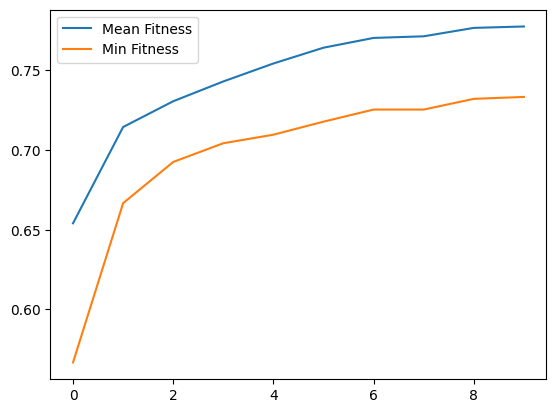

In [12]:
# graph fitnesses
import matplotlib.pyplot as plt

plt.plot(mean_fitnesses, label='Mean Fitness')
# plt.plot(max_fitnesses, label='Max Fitness')
plt.plot(min_fitnesses, label='Min Fitness')
plt.legend()
plt.show()


In [13]:
print(population[0])

Position: 577, Tag: 'name', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 0, Weight: 1, Parents: [576, 575, 574, 561, 559, 558, 557, 547, 546, 514, 513, 512, 511, 510, 422, 421, 409, 358, 357, 351, 0], Edits: None
Position: 364, Tag: 'modifier', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 0, Weight: 1, Parents: [361, 360, 359, 358, 357, 351, 0], Edits: None
Position: 391, Tag: 'modifier', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 0, Weight: 1, Parents: [389, 388, 387, 358, 357, 351, 0], Edits: None
Position: 406, Tag: 'expr', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 1, Weight: 1, Parents: [405, 401, 399, 398, 397, 358, 357, 351, 0], Edits: None
Position: 247, Tag: 'expr', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 2, Weight: 1, Parents: [246, 245, 244, 243, 242, 228, 0], Edits: None
Positio

In [18]:
population[6].submit_to_evaluation(evaluation_server=settings['evaluation_server'])

{'compile_errors': {'errors': 3, 'warnings': 0},
 'message': 'error compiling code'}